# Hierarchical Risk Parity - usage examples 

## Abstract

Hierarchical Risk Parity is a novel portfolio optimisation method developed by Marcos Lopez de Prado. The working of the
algorithm can be broken down into 3 steps:

1. Assets are segregated into clusters via hierarchical tree clustering.
2. Based on these clusters, the covariance matrix of the returns is reorganized such that assets
   within the same cluster are regrouped together.
3. Finally, the weights are assigned to each cluster in a recursive manner. At each node, the weights are broken down
   into the sub-cluster until all the individual assets are assigned a unique weight.

Although, it is a simple algorithm, HRP has been found to be very stable as compared to its older counterparts.
This is because, HRP does not involve taking inverse of the covariance matrix matrix which makes it robust to small changes
in the covariances of the asset returns.

For a detailed explanation of how HRP works, we have written an excellent `blog post <https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/>`_ about it.

The objective of this notebook is to provide examples on how to use HRP in practice

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlfinlab.portfolio_optimization.hrp import HierarchicalRiskParity
import warnings
warnings.filterwarnings('ignore')

In [40]:
def plot_weights(weights):
    weights = weights.sort_values(by=0, ascending=False, axis=1)
    plt.figure(figsize=(10, 5))
    plt.bar(weights.columns, weights.values[0])
    plt.xlabel('Tickers', fontsize=12)
    plt.ylabel('Weights', fontsize=12)
    plt.title('Portfolio Weights', fontsize=12)
    plt.show()

In [14]:
data = pd.read_csv('../Sample-Data/stock_prices.csv')
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index)
data.head()

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,49.273335,35.389999,106.639999,52.919998,78.220001,87.629997,37.939999,47.759998,41.299999,79.500000,...,42.090000,51.173328,55.983330,74.529999,67.309998,144.929993,94.379997,77.360001,101.400002,130.630005
2008-01-03,49.716667,35.290001,107.000000,53.119999,78.349998,87.809998,37.919998,48.060001,42.049999,80.440002,...,42.029999,51.293331,55.599998,74.800003,67.500000,144.860001,94.250000,77.459999,101.519997,130.740005
2008-01-04,48.223331,34.599998,106.970001,51.759998,76.570000,88.040001,36.990002,46.919998,40.779999,77.500000,...,42.349998,49.849998,54.536671,72.980003,65.769997,141.309998,94.269997,77.550003,101.650002,128.169998
2008-01-07,48.576668,34.630001,106.949997,51.439999,76.650002,88.199997,37.259998,47.060001,40.220001,77.199997,...,43.230000,50.416672,56.116669,72.949997,65.650002,141.190002,94.680000,77.570000,101.720001,128.059998
2008-01-08,48.200001,34.389999,107.029999,51.320000,76.220001,88.389999,36.970001,46.400002,39.599998,75.849998,...,43.240002,49.566669,55.326672,72.400002,65.360001,138.910004,94.570000,77.650002,101.739998,125.849998


In order to work, the Algo needs 2 important matrices:
    * A covariance matrix for estimating the risk associated with each cluster
    * A distance_matrix often derived directly from the covariance allowing to build our clusters
    

## 1. Basic examples

#### First let's give the algo a dataframe or numpy array of raw prices with the corresponding names

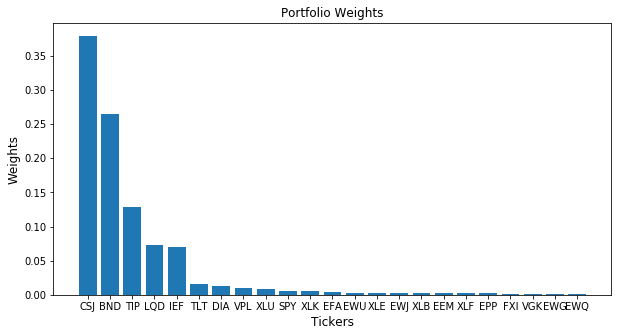

In [22]:
hrp = HierarchicalRiskParity()
hrp.allocate(asset_prices=data, asset_names=data.columns)
plot_weights(hrp.weights)

By default, the algo is asked to build a minimum variance portfolio being long on each asset
The weight number k is just the proportion of your investment allocated to asset number k.

Providing asset prices means the algo will compute the returns, a covariance matrix and the distance matrix.

####  What if I want to give returns instead of price ?

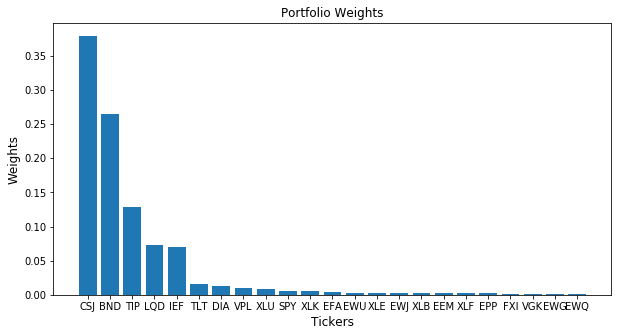

In [38]:
hrp = HierarchicalRiskParity()
returns = data.pct_change()[1:]
hrp.allocate(asset_returns=returns, asset_names=data.columns)
plot_weights(hrp.weights)

As expected, we have found the exact same weights.

Providing asset returns means the algo only need to compute a covariance matrix and the distance matrix

#### But I have my own covariance matrix, already shrinked and proven to perform well out of sample, can I use it?

Of course Voilà

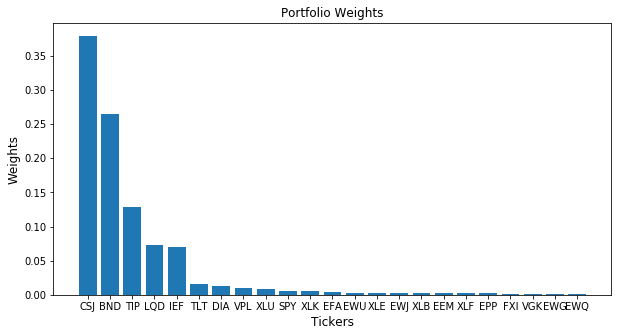

In [47]:
hrp = HierarchicalRiskParity()
my_fav_cov_matrix = returns.cov()
hrp.allocate(covariance_matrix=my_fav_cov_matrix, asset_names=data.columns)
plot_weights(hrp.weights)

Here the algo only has to compute the distance matrix from the covariance matrix

## 2. More advanced examples

#### What if I want to use my prefered linkage method for the tree clustering part?

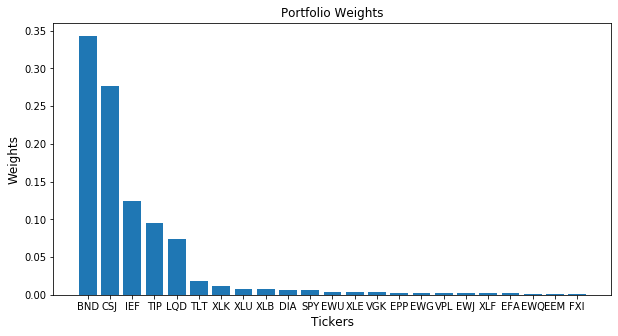

In [48]:
hrp = HierarchicalRiskParity()
my_fav_cov_matrix = returns.cov()
hrp.allocate(covariance_matrix=my_fav_cov_matrix, asset_names=data.columns, linkage_method='ward')
plot_weights(hrp.weights)

By default, HRP uses single linkage but any other technique implemented in scipy could do the job.
The user can test various clustering method and see which one is the most robust for his particular task.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

Note: The weights have changed a little bit compared to the single linkage method used in the Basic example section.

#### How to provide my own distance matrix ?

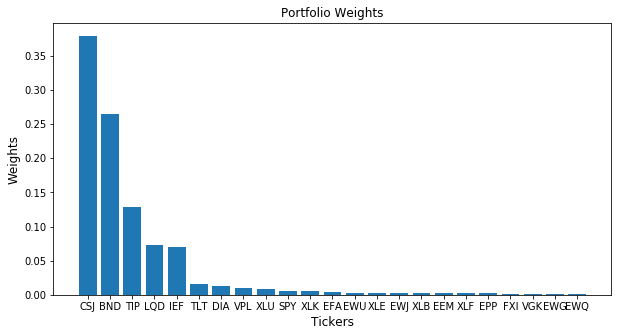

In [53]:
 def cov2corr(covariance):
        """
        Calculate the correlations from asset returns covariance matrix.

        :param covariance: (pd.Dataframe) asset returns covariances
        :return: (pd.Dataframe) correlations between asset returns
        """
        d_matrix = np.zeros_like(covariance)
        diagnoal_sqrt = np.sqrt(np.diag(covariance))
        np.fill_diagonal(d_matrix, diagnoal_sqrt)
        d_inv = np.linalg.inv(d_matrix)
        corr = np.dot(np.dot(d_inv, covariance), d_inv)
        corr = pd.DataFrame(corr, index=covariance.columns, columns=covariance.columns)
        return corr

hrp = HierarchicalRiskParity()
cov = returns.cov()
corr = cov2corr(cov)
distance = np.sqrt((1 - corr).round(5) / 2)
hrp.allocate(distance_matrix=distance, covariance_matrix=cov, asset_names=data.columns)
plot_weights(hrp.weights)

Yes that's exactly the same weights than the ones given by the Basic examples section because that's how HRP computes the distance matrix. Nonetheless, using the same parameter, you can provide your custom distance matrix.

Remember to provide a covariance matrix (or prices, or returns) because the algo needs it to compute the intra cluster variance and then behave accordingly.

#### Is it possible to build a Long/Short portfolio ?

By using the side_weights parameter (pd.Series) with 1 for Buy and -1 for Sell and asset names as index.

Note: The portfolio is dollar neutral 50% is assigned to buys and 50% for sells.

In [73]:
hrp = HierarchicalRiskParity()
side_weights = pd.Series([1]*data.shape[1], index=data.columns)
#Short the first 4 stocks
side_weights.loc[data.columns[:4]] = -1
hrp.allocate(asset_prices=data, asset_names=data.columns, side_weights=side_weights)
side_weights

EEM   -1
EWG   -1
TIP   -1
EWJ   -1
EFA    1
IEF    1
EWQ    1
EWU    1
XLB    1
XLE    1
XLF    1
LQD    1
XLK    1
XLU    1
EPP    1
FXI    1
VGK    1
VPL    1
SPY    1
TLT    1
BND    1
CSJ    1
DIA    1
dtype: int64

In [59]:
side_weights.value_counts()

 1    19
-1     4
dtype: int64

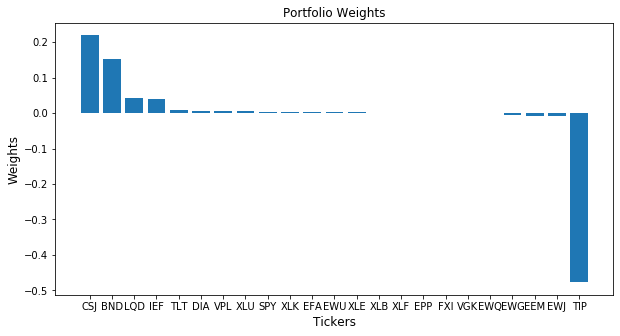

In [55]:
plot_weights(hrp.weights)

In [3]:
short_ptf = side_weights[side_weights==-1].index
buy_ptf = side_weights[side_weights==1].index
weights = hrp.weights.T
print('Proportion $ allocated to short portf:', weights.loc[short_ptf].sum().item())
print('Proportion $ allocated to buy portf:', weights.loc[buy_ptf].sum().item())

Proportion $ allocated to short portf: -0.49999999999999994
Proportion $ allocated to buy portf: 0.5


## Conclusion

HRP is a robust algo for minimum variance portfolio construction and for which the user will find a lot of freedom regarding the input parameters.

You can also look at the HRP performance comparison with other portfolio construction techniques on the following notebook: https://github.com/hudson-and-thames/research/blob/master/Chapter16/Chapter16.ipynb